In [33]:
# import torch
# torch.cuda.is_available()

In [34]:
# import torch
# torch.zeros(1).cuda()

In [35]:
# import tensorflow as tf
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.layers import Dropout
from keras.layers import Bidirectional, Flatten
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

## Fetch Dataset

In [37]:
path = '../Dataset/'

In [38]:
df = pd.read_csv(path+'DelhiDataset_named.csv')
df.dropna(inplace=True)
df.rename(columns = {'label':'classLabel'}, inplace = True)

### Visualize Dataset

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15438 entries, 0 to 15437
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  15438 non-null  int64 
 1   tweet       15438 non-null  object
 2   classLabel  15438 non-null  object
dtypes: int64(1), object(2)
memory usage: 362.0+ KB


In [40]:
df.classLabel.value_counts()

Traffic obstruction/car breakdown    4831
Others                               3459
Traffic congestion/heavy traffic     2821
Road closure                         1487
Water logging                        1156
Traffic information/advisory         1001
City program                          416
Accident                              267
Name: classLabel, dtype: int64

[Text(0, 0, 'Others'),
 Text(1, 0, 'Traffic information/advisory'),
 Text(2, 0, 'Accident'),
 Text(3, 0, 'Traffic congestion/heavy traffic'),
 Text(4, 0, 'Water logging'),
 Text(5, 0, 'City program'),
 Text(6, 0, 'Traffic obstruction/car breakdown'),
 Text(7, 0, 'Road closure')]

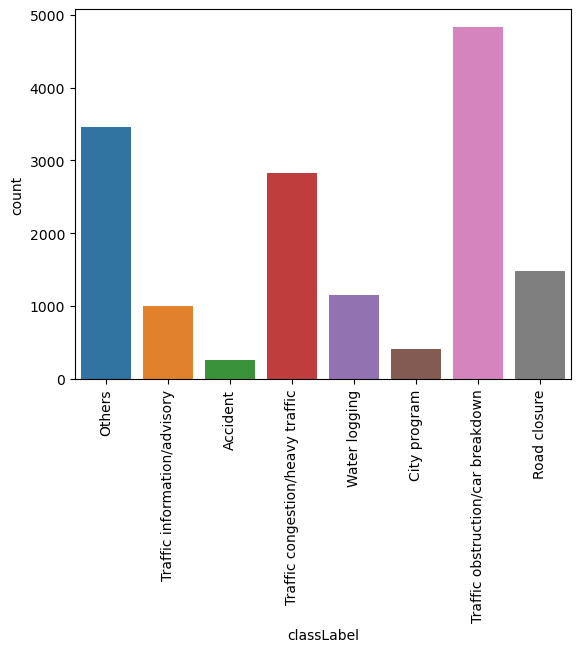

In [41]:
s = sns.countplot(x='classLabel',data=df)
s.set_xticklabels(s.get_xticklabels(),rotation=90)

## Dataset Preprocessing

### Data Cleaning : Stemming and Remove stop words

In [42]:
def print_plot(index):
    example = df[df.index == index][['tweet', 'classLabel']].values[0]
    if len(example) > 0:
        print(example[0])
        print('classLabel:', example[1])

In [43]:
print_plot(10)
print_plot(100)

 BRIG HOSHIYAR SINGH MARG AUROBINDO MARGPRITHVI RAJ ROAD in connection with Airtel Delhi Half Marathon Championship 
classLabel: Others
and to complain online you may also visit at their website 
classLabel: Others


In [44]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string

        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing.
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['tweet'] = df['tweet'].apply(clean_text)

In [45]:
df['tweet'] = df['tweet'].str.replace('\d+', '',regex=False)

In [46]:
print_plot(10)
print_plot(100)

brig hoshiyar singh marg aurobindo margprithvi raj road connection airtel delhi half marathon championship
classLabel: Others
complain online may also visit website
classLabel: Others


### Transormation of X data into 'tokenized embedding'

In [47]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 25000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 120
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['tweet'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 9688 unique tokens.


In [48]:
X = tokenizer.texts_to_sequences(df['tweet'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)
X

Shape of data tensor: (15438, 120)


array([[   0,    0,    0, ..., 4627,    5,  258],
       [   0,    0,    0, ...,    1,   33,   55],
       [   0,    0,    0, ...,  894,   19, 1269],
       ...,
       [   0,    0,    0, ...,  113,  488,    1],
       [   0,    0,    0, ...,  360,  192,   79],
       [   0,    0,    0, ...,  413,    1,   23]], dtype=int32)

### Transormation of Y data into 'Label Binarized '

In [49]:
Y = df['classLabel'].values
lb = LabelBinarizer()
y = lb.fit_transform(Y)
y

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

### Divide data into Train Test

In [50]:
X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(12350, 120) (12350, 8)
(3088, 120) (3088, 8)


## Defining BiLSTM Model

In [51]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf

In [93]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(EMBEDDING_DIM, return_sequences = True ,dropout=0.2, recurrent_dropout=0.2)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(EMBEDDING_DIM, return_sequences = True ,dropout=0.2, recurrent_dropout=0.2)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(EMBEDDING_DIM, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dropout(0.2))

model.add(Dense(y.shape[1], activation='softmax'))
adam = Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
print(model.summary())


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 120, 100)          2500000   
                                                                 
 spatial_dropout1d_6 (Spatia  (None, 120, 100)         0         
 lDropout1D)                                                     
                                                                 
 bidirectional_11 (Bidirecti  (None, 120, 200)         160800    
 onal)                                                           
                                                                 
 dropout_9 (Dropout)         (None, 120, 200)          0         
                                                                 
 bidirectional_12 (Bidirecti  (None, 120, 200)         240800    
 onal)                                                           
                                                      

### Training of model on train Data

In [94]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
import keras
st = time.time()
epochs = 50
batch_size = 32

checkpoint_path = '/home/pratik/notebook/tweetProj/TweetProj/SavedModel/BiLSTM-Delhi/cp-{epoch:03d}-{loss:0.4f}.hdf5'
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    monitor = 'loss',
    mode = min,
    save_best_only = True,
    verbose=1)

history = model.fit(X_train, Y_train, epochs = epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001),cp_callback])

et = time.time()
elapsed_time = et - st
print('Execution time: {:0.0f} seconds'.format(elapsed_time))

model.save('/home/pratik/notebook/tweetProj/TweetProj/SavedModel/BiLSTM-Delhi_model.h5')

import pickle
with open('/home/pratik/notebook/tweetProj/TweetProj/SavedModel/BiLSTM-Delhi_history', 'wb') as file_pi:
    pickle.dump(history, file_pi)



Epoch 1/50
348/348 [==============================] - ETA: 0s - loss: 1.3265 - accuracy: 0.5100
Epoch 1: loss improved from inf to 1.32648, saving model to /home/pratik/notebook/tweetProj/TweetProj/SavedModel/BiLSTM-Delhi/cp-001-1.3265.hdf5
348/348 [==============================] - 186s 481ms/step - loss: 1.3265 - accuracy: 0.5100 - val_loss: 0.9939 - val_accuracy: 0.6251
Epoch 2/50
348/348 [==============================] - ETA: 0s - loss: 0.7307 - accuracy: 0.7340
Epoch 2: loss improved from 1.32648 to 0.73069, saving model to /home/pratik/notebook/tweetProj/TweetProj/SavedModel/BiLSTM-Delhi/cp-002-0.7307.hdf5
348/348 [==============================] - 167s 479ms/step - loss: 0.7307 - accuracy: 0.7340 - val_loss: 0.5452 - val_accuracy: 0.7968
Epoch 3/50
348/348 [==============================] - ETA: 0s - loss: 0.4570 - accuracy: 0.8454
Epoch 3: loss improved from 0.73069 to 0.45699, saving model to /home/pratik/notebook/tweetProj/TweetProj/SavedModel/BiLSTM-Delhi/cp-003-0.4570.hdf5

## Load Model and History

In [73]:
# from tensorflow import keras
# model = keras.models.load_model('/home/pratik/notebook/tweetProj/TweetProj/SavedModel/BiLSTM-Merged_model.h5')
# import pickle
# with open(path+'merged_LSTM_history', "rb") as file_pi:
#   history = pickle.load(file_pi)

## Perform on Test Dataset




In [95]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.2f}\n  Accuracy: {:0.2f}%'.format(accr[0],accr[1]*100))

97/97 [==============================] - 9s 95ms/step - loss: 0.1045 - accuracy: 0.9738
Test set
  Loss: 0.10
  Accuracy: 97.38%


## Result Analysis

### Plot Training Testing Accuracy and Loss

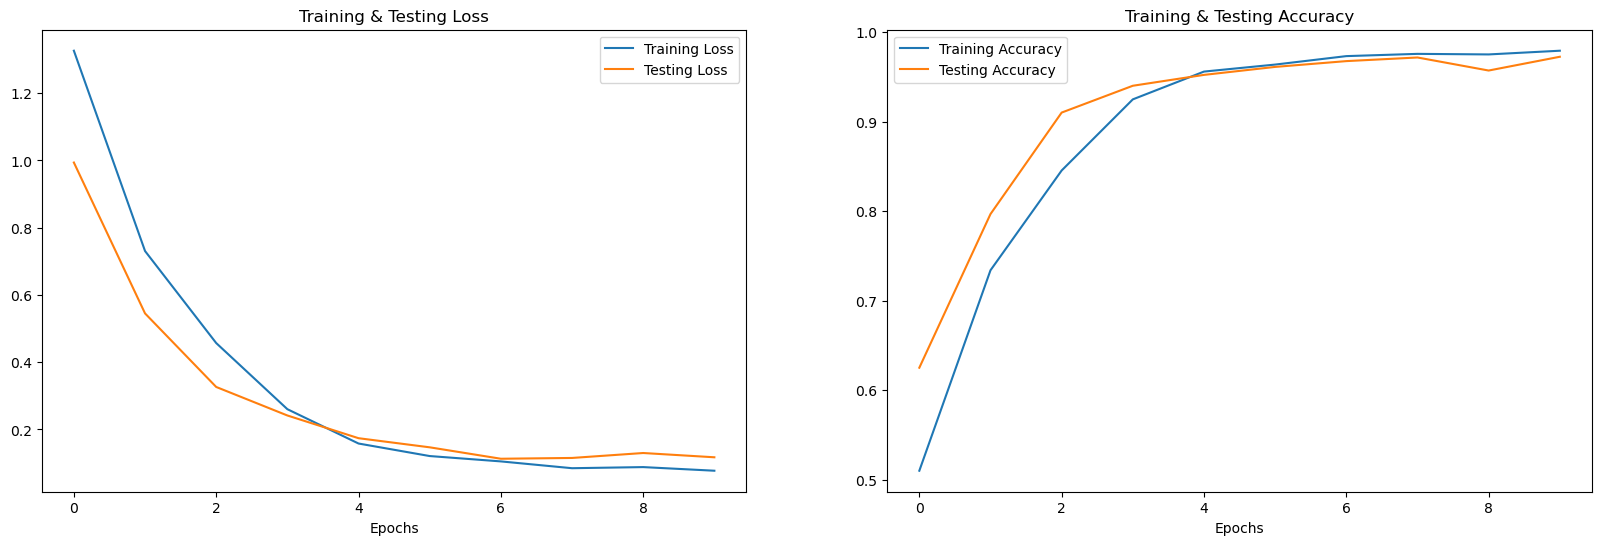

In [96]:
epochList = [i for i in range(len(history.history['loss']))]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochList , train_loss , label = 'Training Loss')
ax[0].plot(epochList , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochList , train_acc , label = 'Training Accuracy')
ax[1].plot(epochList , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

### Prediction of Model on Test Data

In [97]:
pred_test = model.predict(X_test)

97/97 [==============================] - 11s 95ms/step


In [98]:
y_pred = lb.inverse_transform(pred_test)
y_test = lb.inverse_transform(Y_test)

In [99]:
unique, counts = np.unique(y_test, return_counts=True)
print(np.asarray((unique, counts)).T)

[['Accident' '47']
 ['City program' '73']
 ['Others' '685']
 ['Road closure' '325']
 ['Traffic congestion/heavy traffic' '536']
 ['Traffic information/advisory' '191']
 ['Traffic obstruction/car breakdown' '977']
 ['Water logging' '254']]


### Plotting Confusion Matrix

<Figure size 3000x1000 with 0 Axes>

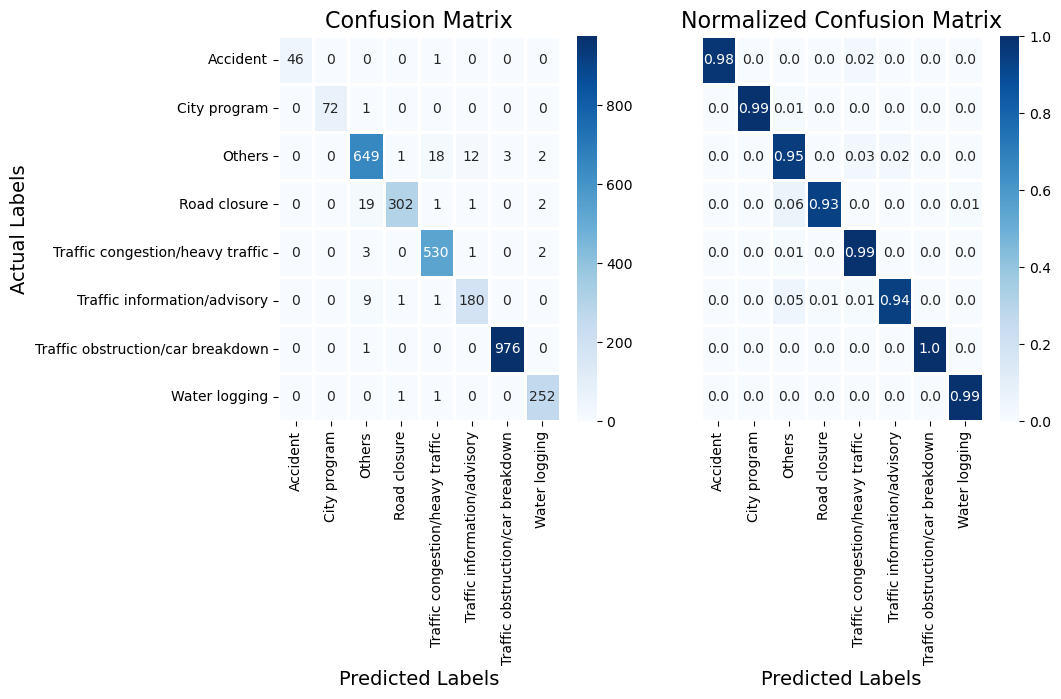

In [100]:
cm = confusion_matrix(y_test, y_pred)
cm1 = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
plt.figure(figsize = (30, 10))
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
cm1 = pd.DataFrame(cm1  , columns = [i for i in lb.classes_])

fig , ax = plt.subplots(1,2,figsize=(10,5))
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=2, annot=True, fmt='',ax=ax[0])
ax[0].set_title('Confusion Matrix', size=16)
ax[0].set_xlabel('Predicted Labels', size=14)
ax[0].set_ylabel('Actual Labels', size=14)

sns.heatmap(cm1, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='',ax=ax[1],yticklabels=False)
ax[1].set_title('Normalized Confusion Matrix', size=16)
ax[1].set_xlabel('Predicted Labels', size=14)
plt.show()

In [101]:
print(classification_report(y_test, y_pred))

                                   precision    recall  f1-score   support

                         Accident       1.00      0.98      0.99        47
                     City program       1.00      0.99      0.99        73
                           Others       0.95      0.95      0.95       685
                     Road closure       0.99      0.93      0.96       325
 Traffic congestion/heavy traffic       0.96      0.99      0.97       536
     Traffic information/advisory       0.93      0.94      0.94       191
Traffic obstruction/car breakdown       1.00      1.00      1.00       977
                    Water logging       0.98      0.99      0.98       254

                         accuracy                           0.97      3088
                        macro avg       0.98      0.97      0.97      3088
                     weighted avg       0.97      0.97      0.97      3088



### Plotting Confusion Matrix

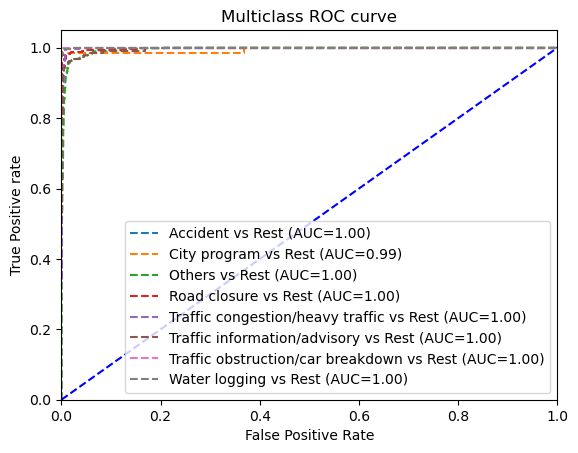

In [102]:
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve,auc

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}
roc_auc = dict()

classes = lb.classes_

for i in range(len(classes)):
    # fpr[i], tpr[i], thresh[i] = roc_curve(y_test_binarized[:,i], pred_prob[:,i])
    fpr[i], tpr[i], thresh[i] = roc_curve(Y_test[:,i], pred_test[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    # plotting
    plt.plot(fpr[i], tpr[i], linestyle='--',
             label='%s vs Rest (AUC=%0.2f)'%(classes[i],roc_auc[i]))

plt.plot([0,1],[0,1],'b--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='lower right')
plt.show()

## Calculating Evaluation Metric

In [103]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import roc_auc_score
accuracy = accuracy_score(y_test, y_pred)
precision, recall, fscore,_  = score(y_test, y_pred, average='macro')
roc_auc = roc_auc_score(y_test, pred_test,multi_class='ovr')
print('Accuracy, precision, recall, fscore, Roc-AUC')
print('{:.3f},{:.3f},{:.3f},{:.3f},{:.3f}'.format(accuracy,precision,recall,fscore,roc_auc))

Accuracy, precision, recall, fscore, Roc-AUC
0.974,0.975,0.971,0.973,0.998


In [104]:
print('{},{:.0f},{:.4f},{:.4f}'.format(len(history.history['loss']),elapsed_time,train_acc[-1],test_acc[-1]))

10,1686,0.9792,0.9725


## Test on Customized Tweet

In [105]:
lb.classes_

array(['Accident', 'City program', 'Others', 'Road closure',
       'Traffic congestion/heavy traffic', 'Traffic information/advisory',
       'Traffic obstruction/car breakdown', 'Water logging'], dtype='<U33')

In [106]:
new_complaint = ['accident on 1 no street']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
print(pred)
print('Label: {}'.format(lb.classes_[np.argmax(pred)]))

1/1 [==============================] - 0s 125ms/step
[[9.9977297e-01 8.3084217e-07 6.3878819e-05 9.9568229e-07 8.7887100e-05
  1.0171006e-08 1.4937649e-05 5.8532085e-05]]
Label: Accident
